In [11]:
require 'torch'
require 'math'
require 'nn'
require 'optim'
require 'gnuplot'
require 'dataset-mnist'
require 'image'
Plot = require 'itorch.Plot'

In [42]:
torch.manualSeed(1)    -- fix random seed so program runs the same every time

-- TODO: play with these optimizer options for the second handin item, as described in the writeup
-- NOTE: see below for optimState, storing optimiser settings
opt = {}         -- these options are used throughout
opt.optimization = 'sgd'
opt.batch_size = 500
opt.train_size = 8000  -- set to 0 or 60000 to use all 60000 training data
opt.test_size = 0      -- 0 means load all data
opt.epochs = 5         -- **approximate** number of passes through the training data (see below for the `iterations` variable, which is calculated from this)

-- NOTE: the code below changes the optimization algorithm used, and its settings
-- remember, the defaults below are not necessarily good
if opt.optimization == 'lbfgs' then
  optimState = {
    learningRate = 1e-1,
    maxIter = 2,
    nCorrection = 10
  }
  optimMethod = optim.lbfgs
elseif opt.optimization == 'sgd' then
  optimState = {
    learningRate = 1e-2,
    weightDecay = 0,
    momentum = 0,
    learningRateDecay = 1e-7
  }
  optimMethod = optim.sgd
elseif opt.optimization == 'adagrad' then
  optimState = {
    learningRate = 1e-1,
  }
  optimMethod = optim.adagrad
else
  error('Unknown optimizer')
end

mnist.download()       -- download dataset if not already there


In [43]:

-- load dataset using dataset-mnist.lua into tensors (first dim of data/labels ranges over data)
function load_dataset(train_or_test, count)
    -- load
    local data
    if train_or_test == 'train' then
        data = mnist.loadTrainSet(count, {32, 32})
    else
        data = mnist.loadTestSet(count, {32, 32})
    end

    -- shuffle the dataset
    local shuffled_indices = torch.randperm(data.data:size(1)):long()
    -- creates a shuffled *copy*, with a new storage
    data.data = data.data:index(1, shuffled_indices):squeeze()
    data.labels = data.labels:index(1, shuffled_indices):squeeze()

    -- TODO: (optional) UNCOMMENT to display a training example
    -- for more, see torch gnuplot package documentation:
    -- https://github.com/torch/gnuplot#plotting-package-manual-with-gnuplot
    --gnuplot.imagesc(data.data[10])
    itorch.image(data.data[10])

    -- vectorize each 2D data point into 1D
    data.data = data.data:reshape(data.data:size(1), 32*32)

    print('--------------------------------')
    print(' loaded dataset "' .. train_or_test .. '"')
    print('inputs', data.data:size())
    print('targets', data.labels:size())
    print('--------------------------------')

    return data
end


<mnist> loading only 8000 examples	
<mnist> done	


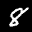

--------------------------------	
 loaded dataset "train"	
inputs	 8000
 1024
[torch.LongStorage of size 2]

targets	 8000
[torch.LongStorage of size 1]

--------------------------------	


In [44]:
train = load_dataset('train', opt.train_size)

<mnist> done	


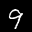

In [45]:
test = load_dataset('test', opt.test_size)

In [46]:
------------------------------------------------------------------------------
-- MODEL
------------------------------------------------------------------------------

n_train_data = train.data:size(1) -- number of training data
n_inputs = train.data:size(2)     -- number of cols = number of dims of input
n_outputs = train.labels:max()    -- highest label = # of classes

print(train.labels:max())
print(train.labels:min())

lin_layer = nn.Linear(n_inputs, n_outputs)
softmax = nn.LogSoftMax() 
model = nn.Sequential()
model:add(lin_layer)
model:add(softmax)

10	
1	


In [47]:
------------------------------------------------------------------------------
-- LOSS FUNCTION
------------------------------------------------------------------------------
criterion = nn.ClassNLLCriterion()

------------------------------------------------------------------------------
-- TRAINING
------------------------------------------------------------------------------
parameters, gradParameters = model:getParameters()

In [48]:
------------------------------------------------------------------------
-- Define closure with mini-batches 
------------------------------------------------------------------------

counter = 0
feval = function(x)
  if x ~= parameters then
    parameters:copy(x)
  end

  -- get start/end indices for our minibatch (in this code we'll call a minibatch a "batch")
  --           ------- 
  --          |  ...  |
  --        ^ ---------<- start index = i * batchsize + 1
  --  batch | |       |
  --   size | | batch |       
  --        v |   i   |<- end index (inclusive) = start index + batchsize
  --          ---------                         = (i + 1) * batchsize + 1
  --          |  ...  |                 (except possibly for the last minibatch, we can't 
  --          --------                   let that one go past the end of the data, so we take a min())
  local start_index = counter * opt.batch_size + 1
  local end_index = math.min(n_train_data, (counter + 1) * opt.batch_size + 1)
  if end_index == n_train_data then
    counter = 0
  else
    counter = counter + 1
  end

  local batch_inputs = train.data[{{start_index, end_index}, {}}]
  local batch_targets = train.labels[{{start_index, end_index}}]
  gradParameters:zero()

  -- In order, these lines compute:
  -- 1. compute outputs (log probabilities) for each data point
  local batch_outputs = model:forward(batch_inputs)
  -- 2. compute the loss of these outputs, measured against the true labels in batch_target
  local batch_loss = criterion:forward(batch_outputs, batch_targets)
  -- 3. compute the derivative of the loss wrt the outputs of the model
  local dloss_doutput = criterion:backward(batch_outputs, batch_targets) 
  -- 4. use gradients to update weights, we'll understand this step more next week
  model:backward(batch_inputs, dloss_doutput)

  -- optim expects us to return
  --     loss, (gradient of loss with respect to the weights that we're optimizing)
  return batch_loss, gradParameters
end

In [49]:
------------------------------------------------------------------------
-- OPTIMIZE: FIRST HANDIN ITEM
------------------------------------------------------------------------
losses = {}          -- training losses for each iteration/minibatch
losses_test = {}    -- test losses
epochs = opt.epochs  -- number of full passes over all the training data
iterations = epochs * math.ceil(n_train_data / opt.batch_size) -- integer number of minibatches to process
-- (note: number of training data might not be divisible by the batch size, so we round up)

-- In each iteration, we:
--    1. call the optimization routine, which
--      a. calls feval(parameters), which
--          i. grabs the next minibatch
--         ii. returns the loss value and the gradient of the loss wrt the parameters, evaluated on the minibatch
--      b. the optimization routine uses this gradient to adjust the parameters so as to reduce the loss.
--    3. then we append the loss to a table (list) and print it
for i = 1, iterations do
  -- optimMethod is a variable storing a function, either optim.sgd or optim.adagrad or ...
  -- see documentation for more information on what these functions do and return:
  --   https://github.com/torch/optim
  -- it returns (new_parameters, table), where table[0] is the value of the function being optimized
  -- and we can ignore new_parameters because `parameters` is updated in-place every time we call 
  -- the optim module's function. It uses optimState to hide away its bookkeeping that it needs to do
  -- between iterations.
  local _, minibatch_loss = optimMethod(feval, parameters, optimState)

  -- Our loss function is cross-entropy, divided by the number of data points,
  -- therefore the units (units in the physics sense) of the loss is "loss per data sample".
  -- Since we evaluate the loss on a different minibatch each time, the loss will sometimes 
  -- fluctuate upwards slightly (i.e. the loss estimate is noisy).
  if i % 10 == 0 then -- don't print *every* iteration, this is enough to get the gist
      print(string.format("minibatches processed: %6s, loss = %6.6f", i, minibatch_loss[1]))
      losses[#losses + 1] = minibatch_loss[1] -- append the new loss
  end
  -- TIP: use this same idea of not saving the test loss in every iteration if you want to increase speed.
  -- Then you can get, 10 (for example) times fewer values than the training loss. If you do this,
  -- you just have to be careful to give the correct x-values to the plotting function, rather than
  -- Tensor{1,2,...,#losses}. HINT: look up the torch.linspace function, and note that torch.range(1, #losses)
  -- is the same as torch.linspace(1, #losses, #losses).
  if i % 10 == 0 then -- don't print *every* iteration, this is enough to get the gist
      -- 1. compute outputs (log probabilities) for each data point
      local test_outputs = model:forward(test.data)
      -- 2. compute the loss of these outputs, measured against the true labels in batch_target
      local test_loss = criterion:forward(test_outputs, test.labels)
      print(string.format("test loss: %6s, loss = %6.6f", i, test_loss))
      losses_test[#losses_test + 1] = test_loss
  end
end

minibatches processed:     10, loss = 1174.075324	


test loss:     10, loss = 809.252037	


minibatches processed:     20, loss = 147.785084	


test loss:     20, loss = 145.275088	


minibatches processed:     30, loss = 80.361152	


test loss:     30, loss = 96.923427	


minibatches processed:     40, loss = 89.890483	


test loss:     40, loss = 95.861881	


minibatches processed:     50, loss = 88.295563	


test loss:     50, loss = 123.325812	


minibatches processed:     60, loss = 87.186078	


test loss:     60, loss = 79.543564	


minibatches processed:     70, loss = 73.794701	


test loss:     70, loss = 91.098378	


minibatches processed:     80, loss = 43.997389	


test loss:     80, loss = 79.178325	


In [50]:
-- TODO: for the first handin item, evaluate test loss above, and add to the plot below
--       see TIP/HINT above if you want to make the optimization loop faster

local plot = Plot()
plot:line(torch.range(1,#losses), torch.Tensor(losses), 'red', 'Training Loss')
plot:line(torch.range(1,#losses), torch.Tensor(losses_test), 'blue', 'Test Loss')
plot:xaxis('Iteration')
plot:legend(true):title('Loss wrt iteration')
plot:draw()

In [51]:
------------------------------------------------------------------------------
-- TESTING THE LEARNED MODEL: 2ND HANDIN ITEM
------------------------------------------------------------------------------

local logProbs = model:forward(test.data)
local classProbabilities = torch.exp(logProbs)
local _, classPredictions = torch.max(classProbabilities, 2)
-- classPredictions holds predicted classes from 1-10

-- TODO: compute test classification error here for the second handin item

accuracy = 0
for i = 1,test:size() do
    if classPredictions[{i,1}] == test.labels[i] then
        accuracy = accuracy + 1
    end
end
print(accuracy, accuracy / test:size()*100 .. '%')

8735	87.35%	
